In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Evaluating with MinMaxScaler
Best parameters found with MinMaxScaler:  {'model__colsample_bytree': 1.0, 'model__gamma': 2.894736842105263, 'model__learning_rate': 0.019999999999999997, 'model__max_depth': 4, 'model__min_child_weight': 4, 'model__n_estimators': 369, 'model__subsample': 0.8888888888888888}
Best cross-validation score with MinMaxScaler:  0.33951604003234676
Evaluating with StandardScaler
Best parameters found with StandardScaler:  {'model__colsample_bytree': 1.0, 'model__gamma': 2.894736842105263, 'model__learning_rate': 0.019999999999999997, 'model__max_depth': 4, 'model__min_child_weight': 4, 'model__n_estimators': 369, 'model__subsample': 0.8888888888888888}
Best cross-validation score with StandardScaler:  0.33951604003234676
Evaluating with RobustScaler
Best parameters found with RobustScaler:  {'model__colsample_bytree': 1.0, 'model__gamma': 2.894736842105263, 'model__learning_rate': 0.019999999999999997, 'model__max_depth': 4, 'model__min_child_weight': 4, 'model__

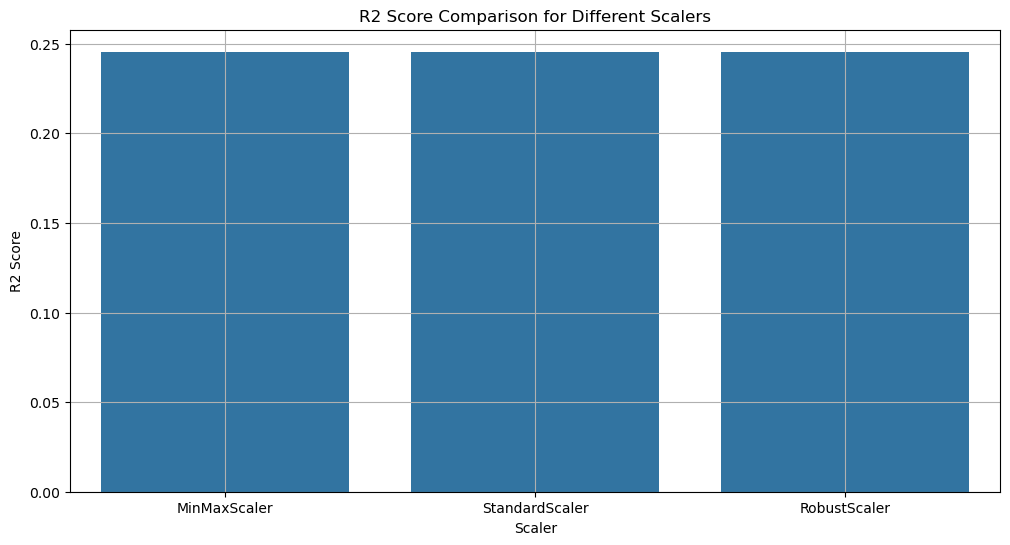

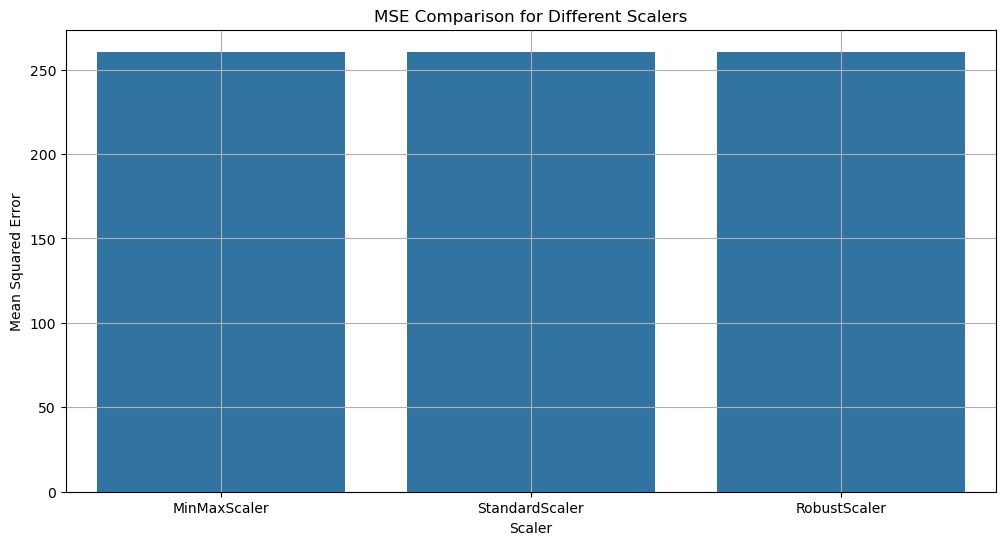

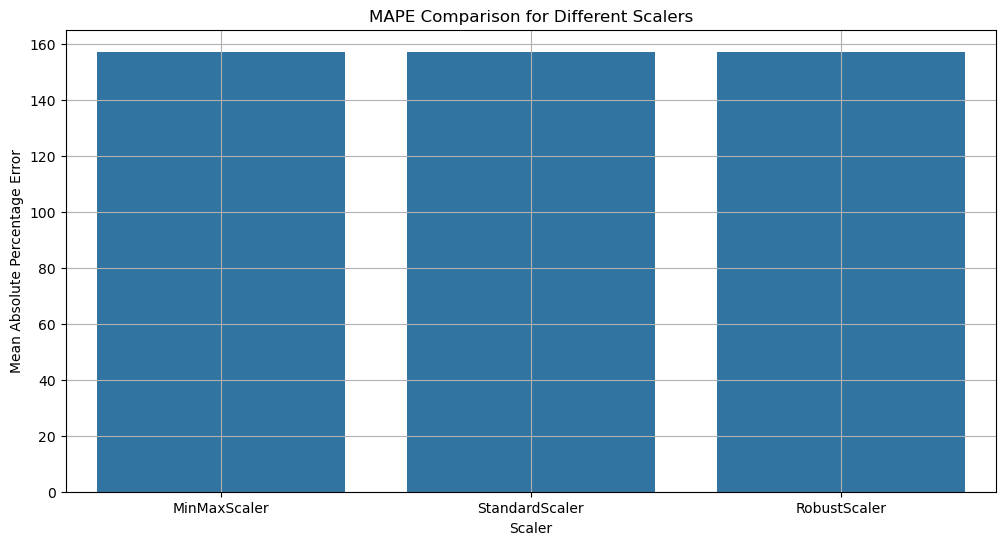

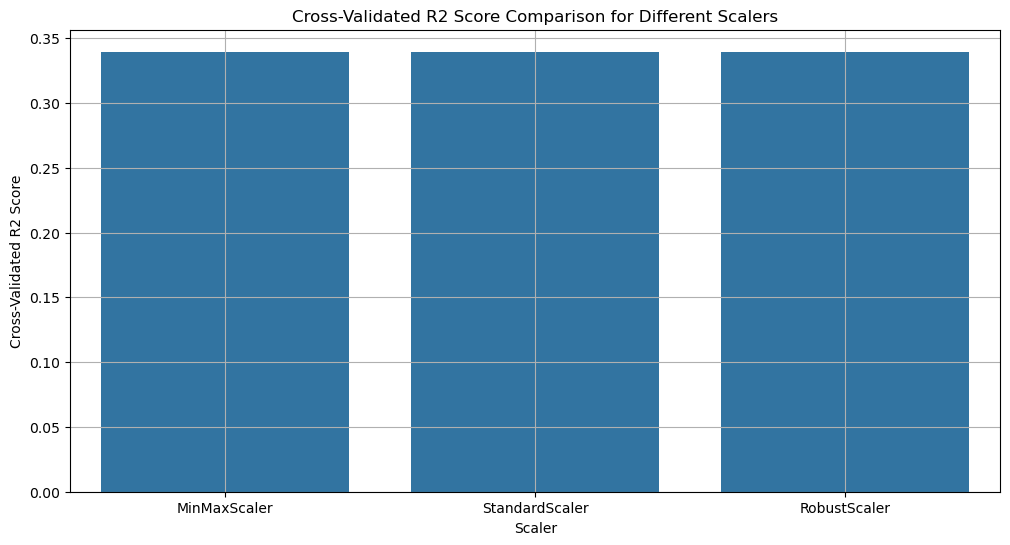

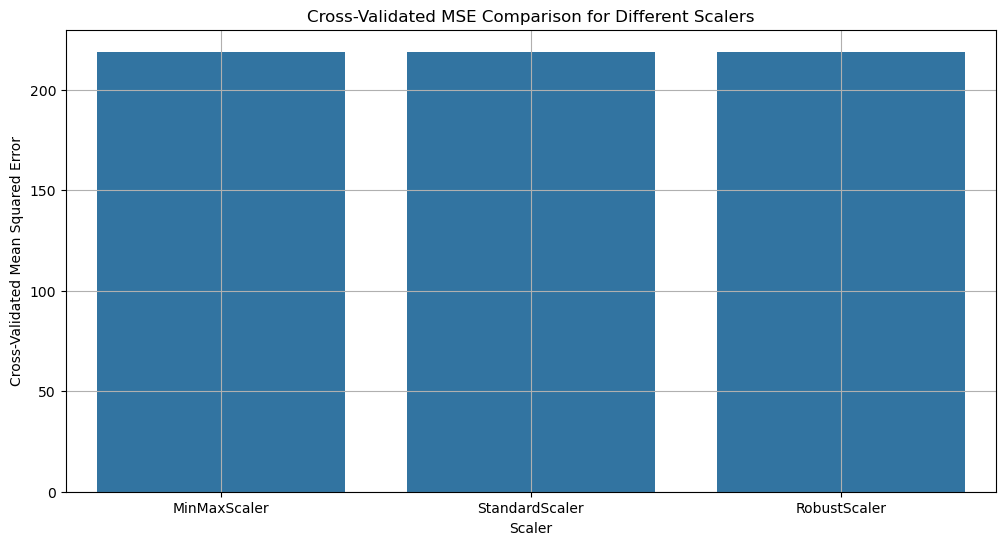

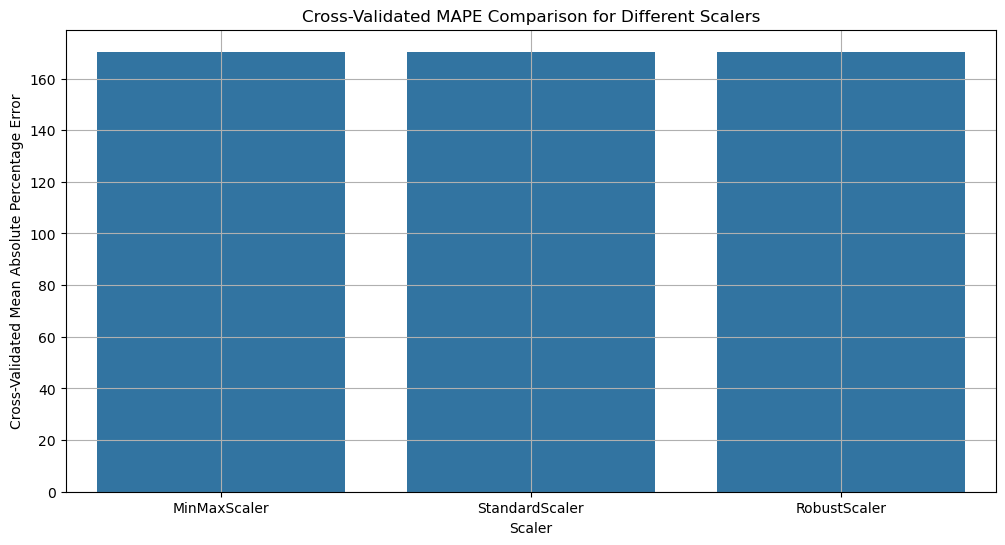

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor

# Load the dataset
file_path = 'Updated_New_cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Remove all columns related to time in seconds, minutes, and hours
columns_to_remove = ['time_diff_sec', 'time_diff_min', 'time_diff_hours']
data_cleaned = data.drop(columns=columns_to_remove)

# Define the target variable
target = 'time_diff_days'
X = data_cleaned.drop(columns=[target])
y = data_cleaned[target]

# Drop all object type columns and specified columns
columns_to_drop = [
    'user_id', 'order_id', 'submit_datetime', 'skuid', 'profile_created_time',
    'profile_created_time_sec', 'order_sumitted', 'COUNTRY',
    'COUNTRY_GROUPED_DE', 'COUNTRY_GROUPED_FR', 'COUNTRY_GROUPED_IN',
    'COUNTRY_GROUPED_Others', 'COUNTRY_GROUPED_US', 'AGE'
]

X = X.drop(columns=columns_to_drop)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scalers to compare
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': sp_randint(100, 1000),
    'model__learning_rate': np.linspace(0.01, 0.3, num=30),
    'model__max_depth': sp_randint(3, 10),
    'model__min_child_weight': sp_randint(1, 10),
    'model__subsample': np.linspace(0.5, 1.0, num=10),
    'model__colsample_bytree': np.linspace(0.5, 1.0, num=10),
    'model__gamma': np.linspace(0, 5, num=20)
}

# Initialize results dictionary
results = []

# Loop through each scaler
for scaler_name, scaler in scalers.items():
    print(f"Evaluating with {scaler_name}")
    
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ])
    
    # Initialize RandomizedSearchCV with verbose output
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, 
        n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Print the best parameters
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    print(f"Best parameters found with {scaler_name}: ", best_params)
    print(f"Best cross-validation score with {scaler_name}: ", best_score)
    
    # Evaluate the best model on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Compute residuals
    residuals = y_test - y_pred
    
    # Perform cross-validation on the training set
    cv_mse = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    cv_mape = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    
    results.append({
        'Scaler': scaler_name,
        'MSE': mse,
        'MAPE': mape,
        'R2': r2,
        'CV_MSE': np.mean(cv_mse),
        'CV_MAPE': np.mean(cv_mape),
        'CV_R2': np.mean(cv_r2),
        'Residuals': residuals,
        'FeatureImportances': best_model.named_steps['model'].feature_importances_
    })

# Create DataFrame for results
results_df = pd.DataFrame(results)


# Plot the comparison results
plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='R2', data=results_df)
plt.title('R2 Score Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('R2 Score')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='MSE', data=results_df)
plt.title('MSE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='MAPE', data=results_df)
plt.title('MAPE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_R2', data=results_df)
plt.title('Cross-Validated R2 Score Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated R2 Score')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_MSE', data=results_df)
plt.title('Cross-Validated MSE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated Mean Squared Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_MAPE', data=results_df)
plt.title('Cross-Validated MAPE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated Mean Absolute Percentage Error')
plt.grid()
plt.show()

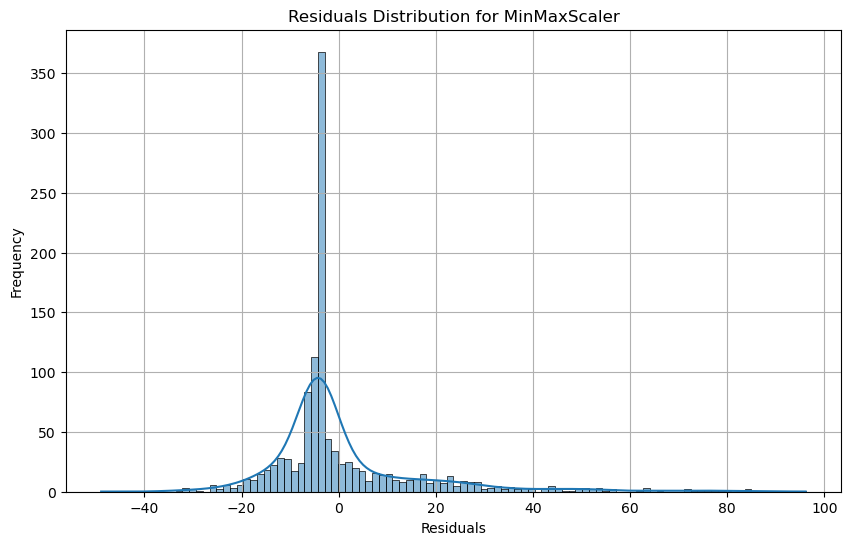

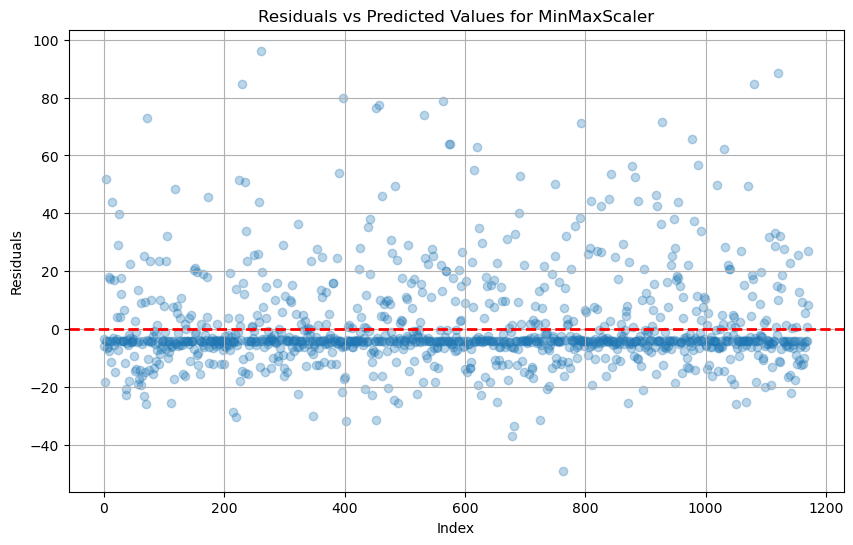

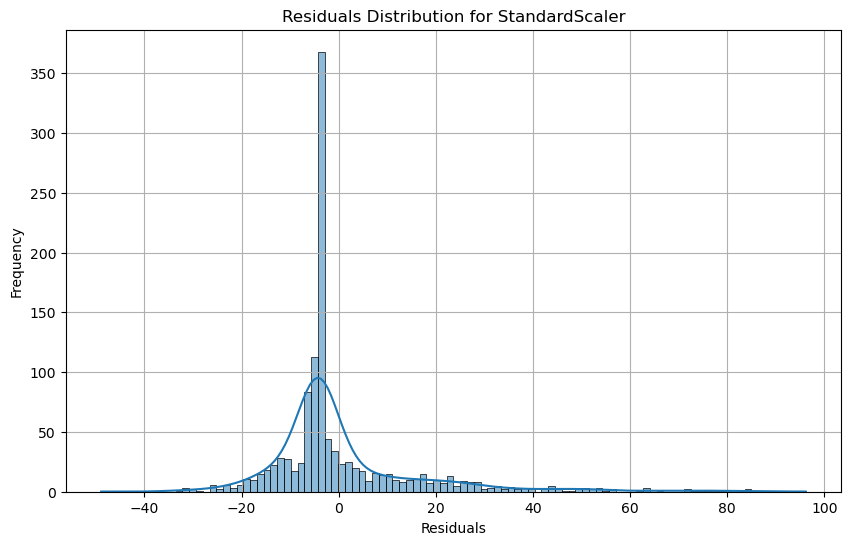

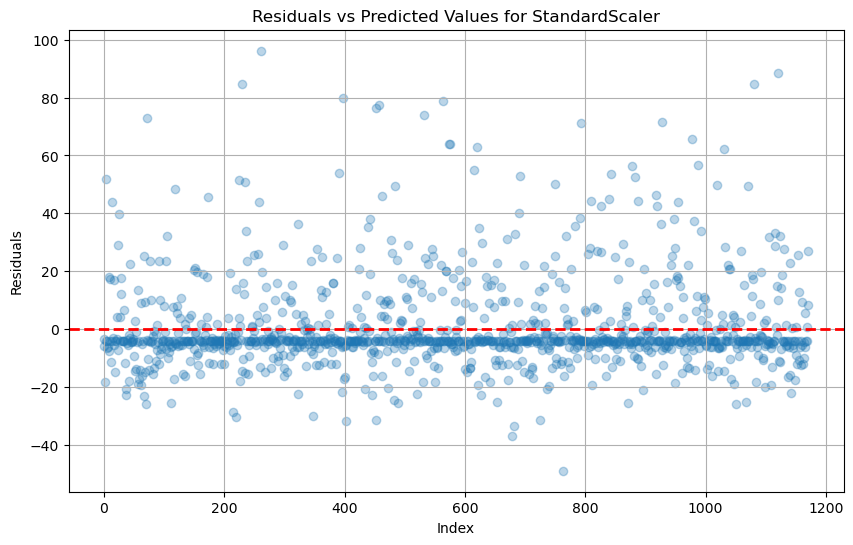

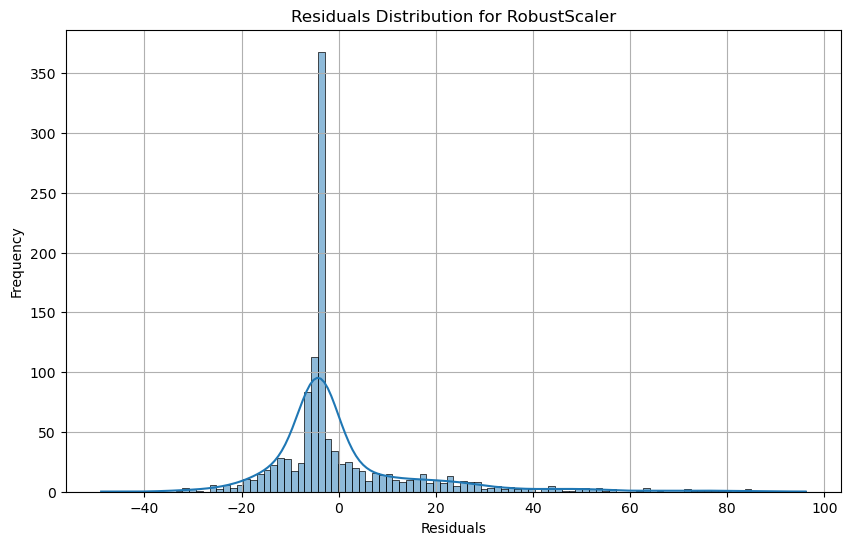

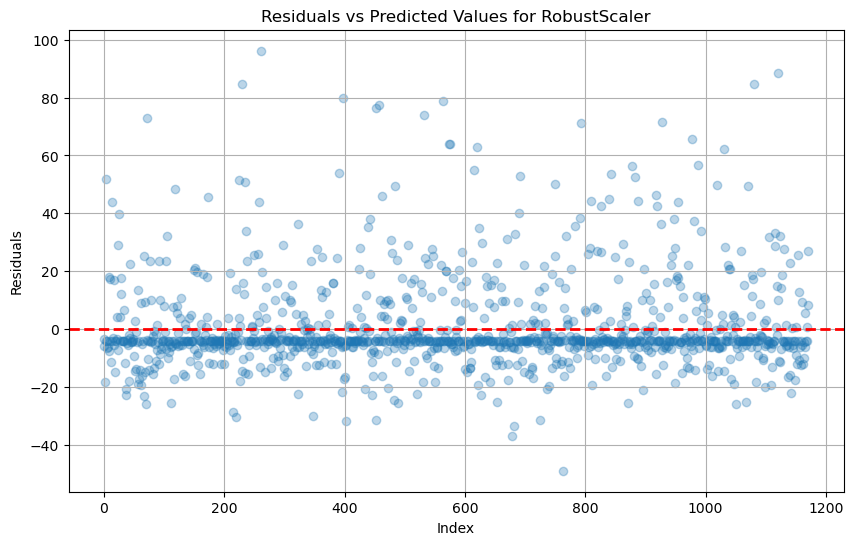

In [3]:
# Analyze residuals for each model
for result in results:
    scaler_name = result['Scaler']
    residuals = result['Residuals']
    
    # Plot histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Residuals Distribution for {scaler_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    # Plot residuals vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(residuals)), residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.title(f'Residuals vs Predicted Values for {scaler_name}')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()


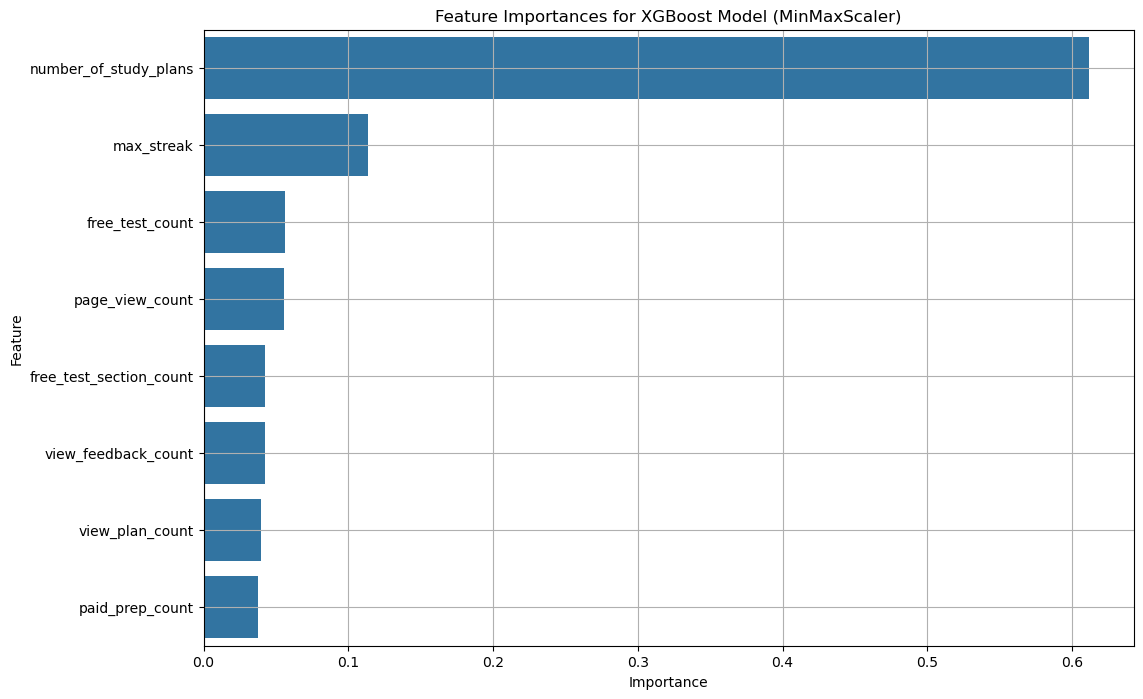

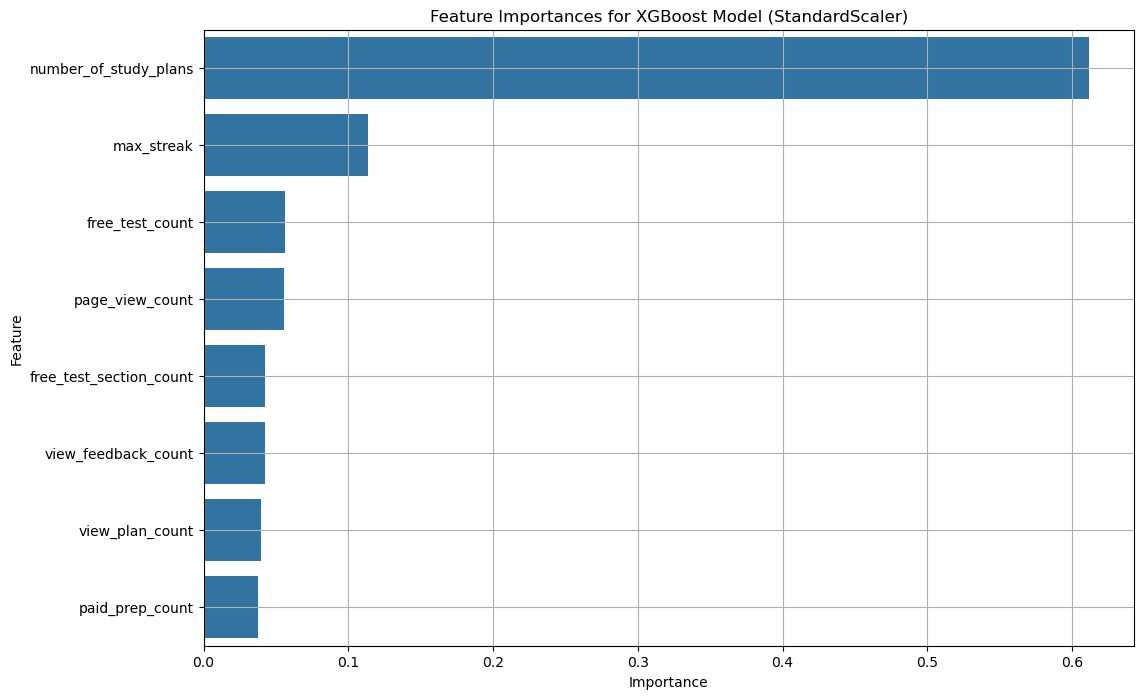

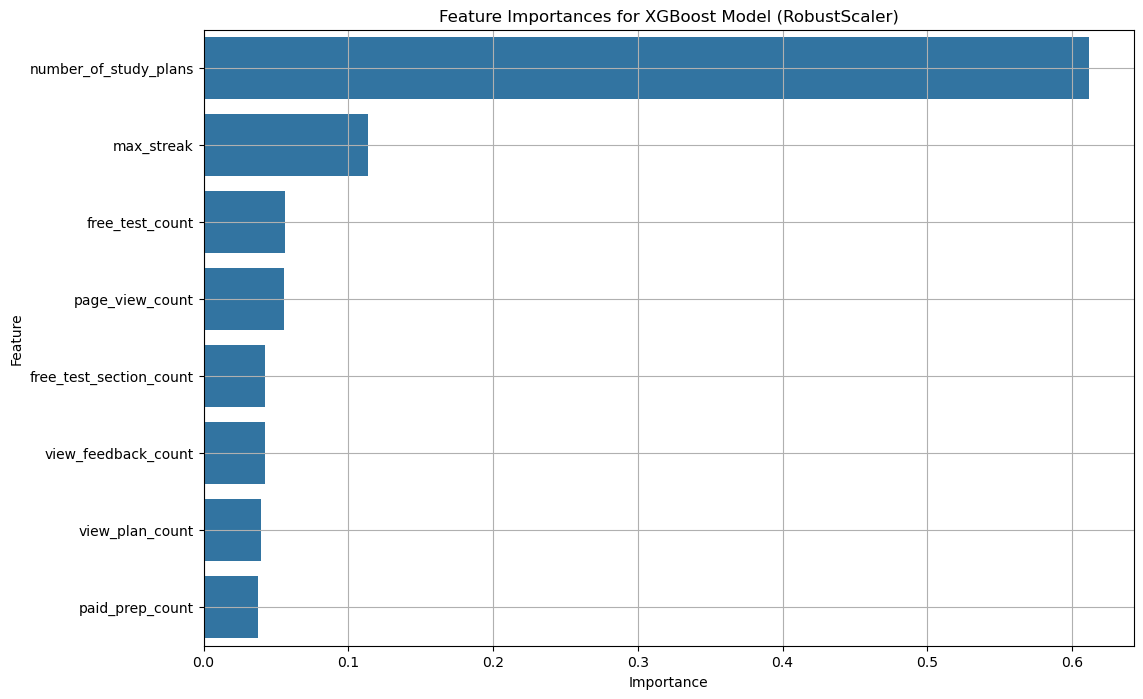

In [4]:
# Feature importance analysis
features = X.columns

for result in results:
    scaler_name = result['Scaler']
    feature_importances = result['FeatureImportances']
    
    # Create a DataFrame for feature importances
    feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    
    # Sort the DataFrame by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title(f'Feature Importances for XGBoost Model ({scaler_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid()
    plt.show()


In [5]:
# Create DataFrame for results
results_df = pd.DataFrame(results)
results_df

,Scaler,MSE,MAPE,R2,CV_MSE,CV_MAPE,CV_R2,Residuals,FeatureImportances
0,MinMaxScaler,260.545721,157.104512,0.245569,218.931219,170.380702,0.339516,5217 -3.484400 3671 -5.978637 1505 -18...,"[0.042586632, 0.05628701, 0.11376378, 0.611896..."
1,StandardScaler,260.545721,157.104512,0.245569,218.931219,170.380702,0.339516,5217 -3.484400 3671 -5.978637 1505 -18...,"[0.042586632, 0.05628701, 0.11376378, 0.611896..."
2,RobustScaler,260.545721,157.104512,0.245569,218.931219,170.380702,0.339516,5217 -3.484400 3671 -5.978637 1505 -18...,"[0.042586632, 0.05628701, 0.11376378, 0.611896..."
